# Entrenamiento de modelos globales usando distintas técnicas para combinar los pesos de los modelos entrenados en distintos folds de los datos de mnist

In [23]:


import tensorflow as tf
import numpy as np
import sys
import matplotlib.pyplot as plt
if ".." not in sys.path:
    sys.path.append("..")


### Ejemplos de los datos

In [24]:
x_test = np.load('../data/x_test.npy')
y_test = np.load('../data/y_test.npy')


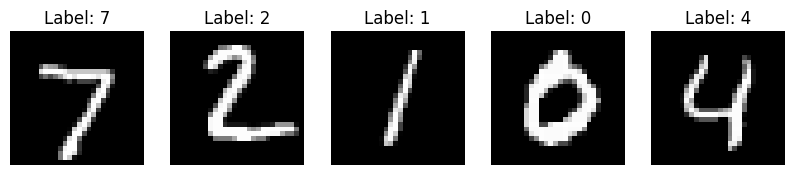

In [25]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(x_test[i], cmap='gray')
    plt.title(f"Label: {y_test[i]}")
    plt.axis('off')

plt.show()

In [26]:
## Abrir los modelos:

import os
loaded_local_models = [tf.keras.models.load_model(os.path.join(root, file)) for root, dirs, files in os.walk("../models") for file in files if file.endswith('.keras')]
#for i in range(len(loaded_local_models)-1):
 #   assert loaded_local_models[i].summary() == loaded_local_models[i+1].summary(), "Models have different architectures"

d:\claseCloud\federated-models\.venv\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


# Federated averaging

**Cambiar descripción para entrega final**

Federated averaging (FedAvg) is a generalization of FedSGD, which allows local nodes to perform more than one batch update on local data and exchanges the updated weights rather than the gradients. The rationale behind this generalization is that in FedSGD, if all local nodes start from the same initialization, averaging the gradients is strictly equivalent to averaging the weights themselves. Further, averaging tuned weights coming from the same initialization does not necessarily hurt the resulting averaged model's performance.[20] Variations of FedAvg based on adaptive optimizers such as ADAM and AdaGrad have been proposed, and generally outperform FedAvg.[21] 

In [27]:
from src.modelG import build

local_weights = [x.get_weights() for x in loaded_local_models]
averaged_weights = [np.mean(np.array(weights), axis=0) for weights in zip(*local_weights)]

global_model = build.build_it()
global_model.set_weights(averaged_weights)

from sklearn.metrics import classification_report
# Predict the classes for the test set
y_pred = global_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_classes))

global_model.save('../models/global_modelFEDAVG.keras')


     


d:\claseCloud\federated-models\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       0.00      0.00      0.00      1135
           2       0.00      0.00      0.00      1032
           3       0.00      0.00      0.00      1010
           4       0.04      0.09      0.05       982
           5       0.00      0.00      0.00       892
           6       0.11      0.86      0.19       958
           7       0.00      0.00      0.00      1028
           8       0.00      0.00      0.00       974
           9       0.00      0.00      0.00      1009

    accuracy                           0.09     10000
   macro avg       0.01      0.10      0.02     10000
weighted avg       0.01      0.09      0.02     10000



d:\claseCloud\federated-models\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\claseCloud\federated-models\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\claseCloud\federated-models\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# IDA (Inverse Distance Aggregation)

**Cambiar para entrega final**

 is a novel adaptive weighting approach for clients based on meta-information which handles unbalanced and non-iid data. It uses the distance of the model parameters as a strategy to minimize the effect of outliers and improve the model's convergence rate

In [28]:
import numpy as np
from src.modelG import build

# Build the global model
global_model = build.build_it()
global_weights = global_model.get_weights()

# Gather client models
local_weights = [model.get_weights() for model in loaded_local_models]

# Compute distances between each local model and the current global model
def compute_distance(w1, w2):
    return np.sqrt(sum([np.sum((a - b) ** 2) for a, b in zip(w1, w2)]))

epsilon = 1e-10
distances = [compute_distance(w, global_weights) for w in local_weights]

# Compute inverse distance weights
inv_dist_weights = [1 / (d + epsilon) for d in distances]
weight_sum = sum(inv_dist_weights)
norm_weights = [w / weight_sum for w in inv_dist_weights]

# Aggregate weighted model parameters
aggregated_weights = []
for layer_idx, layer_weights in enumerate(zip(*local_weights)):  # Each layer across clients
    weighted_sum = np.zeros_like(layer_weights[0])
    for client_idx, client_weights in enumerate(local_weights):
        weighted_sum += norm_weights[client_idx] * layer_weights[client_idx]
    aggregated_weights.append(weighted_sum)
    
# Update the global model
global_model.set_weights(aggregated_weights)

# Evaluate the model
y_pred = global_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_classes))

global_model.save('../models/global_modelIDA.keras')



d:\claseCloud\federated-models\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       0.00      0.00      0.00      1135
           2       0.00      0.00      0.00      1032
           3       0.00      0.00      0.00      1010
           4       0.05      0.12      0.07       982
           5       0.00      0.00      0.00       892
           6       0.11      0.84      0.19       958
           7       0.00      0.00      0.00      1028
           8       0.00      0.00      0.00       974
           9       0.00      0.00      0.00      1009

    accuracy                           0.09     10000
   macro avg       0.02      0.10      0.03     10000
weighted avg       0.01      0.09      0.02     10000



d:\claseCloud\federated-models\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\claseCloud\federated-models\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\claseCloud\federated-models\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Federated stochastic gradient descent (FedSGD)

**Cambiar la descripción para la entrega**

Deep learning training mainly relies on variants of stochastic gradient descent, where gradients are computed on a random subset of the total dataset and then used to make one step of the gradient descent.

Federated stochastic gradient descent[19] is the direct transposition of this algorithm to the federated setting, but by using a random fraction C {\displaystyle C} of the nodes and using all the data on this node. The gradients are averaged by the server proportionally to the number of training samples on each node, and used to make a gradient descent step. 

In [29]:
import numpy as np
from src.modelG import build



# Build the global model
global_model = build.build_it()

# Step 1: Get gradients from each local model
grads_list = []
folds=[0,1,4]
for local_model in range(len(loaded_local_models)):
    x_train = np.load(f'../data/x_train_fold_{folds[local_model]}.npy')
    y_train = np.load(f'../data/y_train_fold_{folds[local_model]}.npy')
    with tf.GradientTape() as tape:
        y_pred = loaded_local_models[local_model](x_train, training=True)
        loss = loaded_local_models[local_model].compiled_loss(y_train, y_pred)
    grads = tape.gradient(loss, loaded_local_models[local_model].trainable_variables)
    grads_list.append(grads)

# Step 2: Average the gradients across clients
average_grads = []
for grads in zip(*grads_list):
    stacked = np.stack([g.numpy() for g in grads], axis=0)
    avg = np.mean(stacked, axis=0)
    average_grads.append(tf.convert_to_tensor(avg))

# Step 3: Apply the averaged gradients to the global model
optimizer = global_model.optimizer
optimizer.apply_gradients(zip(average_grads, global_model.trainable_variables))

# Step 4: Evaluate the model
y_pred = global_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_classes))

global_model.save('../models/global_modelFEDSGD.keras')


d:\claseCloud\federated-models\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
d:\claseCloud\federated-models\.venv\Lib\site-packages\keras\src\backend\tensorflow\trainer.py:665: UserWarning: `model.compiled_loss()` is deprecated. Instead, use `model.compute_loss(x, y, y_pred, sample_weight, training)`.
  warnings.warn(


IndexError: list index out of range